In [ ]:
%%HTML
<style>
th {
  font-size: 24px
}
td {
  font-size: 16px
}
</style>

In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")

# Introduction to tensors

Free after  https://www.manning.com/books/deep-learning-with-pytorch

## Core concepts of this section

1. A `Tensor` is a `View` onto a `Storage`
2. `contiguous` memory layout enables fast computations
3. `broadcasting`: expand Tensor dimensions as needed


## Fundamentals
### Contrast to python list

<!-- ![](../img/memory.png "src: ") -->
<div align="center">
    <img src="../img/memory.svg" width="1200px" alt="in pytorch, a tensor refers to numbers in memory that are all next to each other">
</div>

    
| entity | plain python | pytorch| 
|:-------|:------------:|:------:|
| numbers | **boxed**: objects with reference counting | 32 bit numbers| 
| lists | sequential (1dim) collections of pointers to python objects | **adjacent entries in memory**: optimized for computational operations | 
| interpreter | slow list and math operations | fast | 


### Instantiation

Default type at instantiation is torch.float32

In [3]:
a = torch.ones(3); print(a, a.dtype)
b = torch.zeros((3, 2)).short(); print(b)
c = torch.tensor([1.,2.,3.], dtype=torch.double); print(c)

tensor([1., 1., 1.]) torch.float32
tensor([[0, 0],
        [0, 0],
        [0, 0]], dtype=torch.int16)
tensor([1., 2., 3.], dtype=torch.float64)


In [4]:
torch.tensor??

Docstring:
tensor(data, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor

Constructs a tensor with :attr:`data`.

.. warning::

    :func:`torch.tensor` always copies :attr:`data`. If you have a Tensor
    ``data`` and want to avoid a copy, use :func:`torch.Tensor.requires_grad_`
    or :func:`torch.Tensor.detach`.
    If you have a NumPy ``ndarray`` and want to avoid a copy, use
    :func:`torch.as_tensor`.

.. warning::

    When data is a tensor `x`, :func:`torch.tensor` reads out 'the data' from whatever it is passed,
    and constructs a leaf variable. Therefore ``torch.tensor(x)`` is equivalent to ``x.clone().detach()``
    and ``torch.tensor(x, requires_grad=True)`` is equivalent to ``x.clone().detach().requires_grad_(True)``.
    The equivalents using ``clone()`` and ``detach()`` are recommended.

Args:
    data (array_like): Initial data for the tensor. Can be a list, tuple,
        NumPy ``ndarray``, scalar, and other types.
    dtype (:class:`torch.d

### Tensors and storages

* the `torch.Storage` is where the numbers actually are
* A `torch.Tensor` is a view onto a *torch.Storage*


In [5]:
a = torch.tensor([1,2,3,4,5,6])
b = a.reshape((3,2))
assert id(a.storage()) == id(b.storage())

* layout of the storage is always *1D*
* hence, changing the value in the storage changes the values of all views (i.e. torch.Tensor) that refer to the same storage 

### Size, storage offset, and strides

<div align="center">
    <img src="../img/tensor.svg" width="1200px" alt="Meaning of size, offset and stride">
</div>

* A Tensor is a view on a storage that is defined by its
  * **size:** `t.size()` / `t.shape`
  * **storage offset:** `t.stoage_offset()`
  * **stride:** `t.stride()`
* the **stride** informs how many elements in the storage one needs to move to get to the next value in that dimension
* to get `t[i,j]`, get `storage_offset + i * stride[0] + j * stride[1]` of storage
* this makes some tensor operations very cheap, because a new tensor has the same storage but different values for size, offset and stride

In [6]:
a = torch.tensor([[1,2,3], [4,5,6]])
print(f"a.size: {a.size()}")
print(f"a.storage_offset: {a.storage_offset()}")
print(f"a.stride: {a.stride()}")

a.size: torch.Size([2, 3])
a.storage_offset: 0
a.stride: (3, 1)


In [7]:
b = a[1]
print(f"b.size: {b.size()}")
print(f"b.storage_offset: {b.storage_offset()}")
print(f"b.stride: {b.stride()}")

b.size: torch.Size([3])
b.storage_offset: 3
b.stride: (1,)


#### Transposing a tensor

* the transpose just swaps entries in size and stride

<div align="center">
    <img src="../img/transpose.svg" width="1200px" alt="Transpose explained">
</div>


#### Contiguous

* A tensor whose values are laid out in the storage starting from the right most dimension onward is **contiguous**
  * e.g. 2D tensor:
    * `t.size() # torch.Size([#rows, #columns])`
    * moving along rows (i.e. fix row, go from one column to the next) is equivalent to going through storage one by one
* this data locality improves performance

In [8]:
a = torch.tensor([[1,2,3], [4,5,6]])
assert a.is_contiguous()

In [9]:
b = a.t()
assert not b.is_contiguous()

In [10]:
c = b.contiguous()
assert c.is_contiguous()

### Numeric types

* `torch.floatXX`: 32: float, 64: double, 16: half
* `torch.intXX`: 8, 16, 32, 64
* `torch.uint8`: torch.ByteTensor
* `torch.Tensor`: equivalent to torch.FloatTensor


### Exercises

1. Create a tensor a from list(range(9)) . Predict then check what the size, offset, and strides are.
2. Create a tensor b = a.view(3, 3) . What is the value of b[1,1] ?
3. Create a tensor c = b[1:,1:] . Predict then check what the size, offset, and strides are.

## Indexing and Broadcasting



### Indexing

* similar to [numpy indexing](https://numpy.org/devdocs/user/basics.indexing.html), e.g. `points[1:, 0]`: all but first rows, first column

#### Tips and tricks

In [11]:
# Pairwise indexing works
t = torch.tensor(range(1, 10)).reshape(3, -1)
diagonal = t[range(3), range(3)]
diagonal

tensor([1, 5, 9])

In [12]:
# Inject additional dimensions with indexing

t = torch.rand((3, 64, 64))

# Index with `None` at second dim to `unsqeeze`.
assert t[:, None].shape == torch.Size([3, 1, 64, 64])

# Do it multiple times
assert t[:, None, : , None].shape == torch.Size([3, 1, 64, 1, 64])

# Can also use ellipsis
assert t[..., None].shape == torch.Size([3, 64, 64, 1])

### Boardcasting

Look at the examples below and think about why we can multiply two tensors of different shapes and get the result that one would expect?

In [13]:
# Example 1:
a = torch.tensor([
    3
])
b = torch.tensor([
    1, 2, 3
])
torch.testing.assert_allclose(a*b, torch.tensor([
    3, 6, 9
]))

# Example 2:
a = torch.tensor([
    [1, 2],
    [3, 4]
])
b = torch.tensor([
    1, 2
])
torch.testing.assert_allclose(a*b, torch.tensor([
    [1, 4],
    [3, 8]
]))

The answer is that PyTorch magically *expands* the shape of the tensors in a smart way such that operations can be performed.
&rarr; This is called **broadcasting**.

### How is broadcasting done?

1. Compare the dimensions of all tensors, starting from the trailing one.
2. If dims are the same, do nothing
3. If one dim is 1 (or missing), expand it to match the other dim.
4. Else: abort

**Note:** When broadcasting, PyTorch does not acutally need to expand the dimensions of a tensor in memory in order to perform efficient tensor operations.

```
Example 1
[a]:    3 x 64 x 64
[b]:              1
[a*b]:  3 x 64 x 64

Example 2
[a]:    3 x  1 x 64
[b]:    1 x 64 x  1
[a*b]:  3 x 64 x 64
```

### Exercises

4. Indexing: Get the diagonal elements of `t.rand(3, 3)` by reshaping into a 1d tensor and taking every fourth element, starting from the first.
5. Broadcasting: Write down the shapes of the tensors in the examples and convince yourself that the output shape is as expected.

In [14]:
# TODO: Exercise 4

t = torch.rand(3,3)
diag_expected = t[range(3), range(3)]

diag_actual = t.reshape(-1)[::4]

torch.testing.assert_allclose(diag_actual, diag_expected)

# Tensor features

In [15]:
t = torch.tensor([1,2,3,4,5,6])

### Numpy interoperability

In [16]:
t_np = t.numpy()
t = torch.from_numpy(t_np)

### Serialization

* use `torch.save(t, "path_to_file.t")` and `torch.load("path_to_file.t")`
* alternatively, can use in combination with `hdf5` file format (library: h5py)

### GPU

* pytorch makes it very easy to use one or several GPUs, using the `torch.device`

In [17]:
torch.device("cpu") # use cpu by default
torch.device("cuda") # GPU
torch.device("cuda:0") # index multiple GPUs #0 -> default: 0
torch.device("cuda:1") # use GPU #1

device(type='cuda', index=1)

* delegate a tensor to a device using

In [18]:
print(t.to(torch.device("cpu")))
print(t.cpu())

if torch.cuda.is_available():
    print(t.cuda())
    print(t.cuda(0))

tensor([1, 2, 3, 4, 5, 6])
tensor([1, 2, 3, 4, 5, 6])
tensor([1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([1, 2, 3, 4, 5, 6], device='cuda:0')


### Tensor API

For pytorch, there exists a ton of ops... whatever you would like to do, it's probably already implemented in a performant manner.

**Pytorch convention:** a mathemtical operation often has an in-place equivalent referenced by using the suffix `_`. E.g. `t.cos()` and `t.cos_()`

Some examples:

In [19]:
t = torch.tensor(range(10), dtype=torch.float) 

In [20]:
t.cos()

tensor([ 1.0000,  0.5403, -0.4161, -0.9900, -0.6536,  0.2837,  0.9602,  0.7539,
        -0.1455, -0.9111])

In [21]:
t.log()

tensor([  -inf, 0.0000, 0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459, 2.0794,
        2.1972])

In [22]:
t.log_(); t # operates in-place/ mutates tensor

tensor([  -inf, 0.0000, 0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459, 2.0794,
        2.1972])

### Exercise 6

Caclulate the mean squared error between predictions and target values: $\rm mse = \frac{1}{N}\sum_i^N (p_i - t_i)^2$

In [23]:
def mse(p, t):
    # TODO: Exercise
    return (p-t).pow(2).mean()

x = torch.tensor([0.8878, 0.3297, 0.5110, 0.5384, 0.2123, 0.3426, 0.7011, 0.8208, 0.8864, 0.6434, 0.1740, 0.0737, 0.8329, 0.0571, 0.6244, 0.9390, 0.5501, 0.6998, 0.7668, 0.5981, 0.1187, 0.6488, 0.3909, 0.8849, 0.3510, 0.7472, 0.4878, 0.2781, 0.5326, 0.1480, 0.4136, 0.4267, 0.6989, 0.3887, 0.5068, 0.5511, 0.5643, 0.0901, 0.1359, 0.5701, 0.4774, 0.9935, 0.1502, 0.7608, 0.4538, 0.4217, 0.1825, 0.9382, 0.8646, 0.1383, 0.0363, 0.2364, 0.1937, 0.2695, 0.4807, 0.7768, 0.2784, 0.3547, 0.0922, 0.5994, 0.0868, 0.0460, 0.0812,
        0.0319, 0.2429, 0.3504, 0.6014, 0.9268, 0.2222, 0.5592, 0.2112, 0.3517, 0.1994, 0.3877, 0.8518, 0.3747, 0.9385, 0.5225, 0.9855, 0.7657, 0.5585, 0.0929, 0.5815, 0.0804, 0.9209, 0.8802, 0.6289, 0.9143, 0.0038, 0.7857, 0.9591, 0.8305, 0.1844, 0.0162, 0.1324, 0.0526, 0.2213, 0.6377, 0.6446, 0.6945])
y = torch.tensor([0.2142, 0.7458, 0.7008, 0.2043, 0.1460, 0.2145, 0.7116, 0.6624, 0.8765, 0.2938, 0.4653, 0.1229, 0.8056, 0.2956, 0.4171, 0.0459, 0.3799, 0.5624, 0.4551, 0.1322, 0.7540, 0.0425, 0.3713, 0.4406, 0.8243, 0.5511, 0.1352, 0.7495, 0.0901, 0.2131, 0.7758, 0.9060, 0.7875, 0.5118, 0.5368, 0.3445, 0.8501, 0.2982, 0.2606, 0.4571, 0.8108, 0.7400, 0.2336, 0.6150, 0.9143,
        0.4178, 0.2335, 0.5490, 0.4379, 0.3335, 0.8449, 0.6327, 0.1062, 0.4313, 0.7856, 0.6156, 0.3859, 0.5551, 0.4448, 0.3231, 0.3505, 0.3295, 0.8727, 0.9072, 0.9495, 0.6936, 0.5648, 0.0132, 0.2811, 0.5219, 0.4193, 0.8747, 0.7140, 0.6307, 0.0449, 0.4598, 0.0337, 0.3839, 0.7451, 0.2710, 0.3802, 0.8890, 0.8482, 0.6723, 0.7480, 0.1293, 0.6862, 0.8104, 0.3573, 0.7695, 0.1230, 0.3649, 0.8067, 0.2198, 0.3240, 0.1938, 0.8909, 0.1115, 0.4997, 0.4708])

torch.testing.assert_allclose(mse(x, y), 0.16112)
torch.testing.assert_allclose(mse(torch.ones(3), torch.ones(3)), 0)

2. The [Group Normalizatoin Paper](https://arxiv.org/pdf/1803.08494.pdf) shows a nice figure on how different normalization schemes slice a tensor.

![Figure](../img/group_norm.png)

Choose one scheme and normalize the below tensor accordingly!

In [24]:
N_BATCH_SIZE, C_NUMBER_OF_CHANNELS, H_HEIGHT, W_WIDTH = 32, 3, 64, 64

t = torch.rand(N_BATCH_SIZE, C_NUMBER_OF_CHANNELS, H_HEIGHT, W_WIDTH)

# TODO: Exercise
# Example batch norm
BN_DIMS = (0, 2, 3)
print(t.mean(BN_DIMS), t.std(BN_DIMS))

m = t.mean(BN_DIMS, True)
s = t.std(BN_DIMS).reshape(1, 3, 1, 1)

t = (t -m)/s
print(t.mean(BN_DIMS), t.std(BN_DIMS))

tensor([0.4994, 0.4996, 0.5003]) tensor([0.2890, 0.2888, 0.2888])
tensor([ 8.2320e-08, -9.4209e-08, -5.1514e-09]) tensor([1., 1., 1.])


## Auto grad

Fundamental to optimization is the ability to perform differntiation. PyTorch does this with its **autograd** framework, which we will dive into now.

<div align="center">
    <img src="../img/autograd.svg" width="1200px" alt="Tracking derivatives through the compute graph">
</div>

### Key Concepts

1. Compute graph and chain rule 
1. `t.requires_grad_()` and `t.grad`
2. `t.backward()`
3. `param.detach` and `torch.no_grad()` 
4. zeroing the gradient
    

### Gradient descent by hand...

We want to find the minimum of a quadratic function and show how PyTorch can help us to do so.

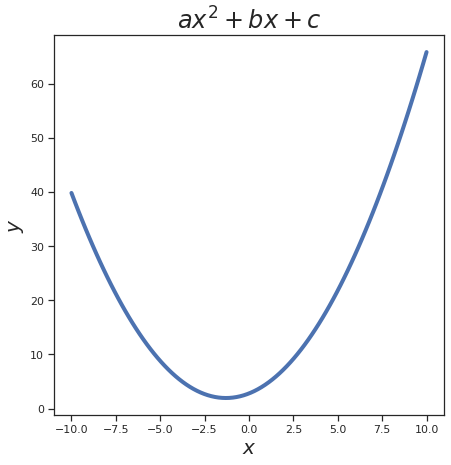

In [25]:
# Define a quadratic function and plot it

def second_order_polynomial(x, a, b, c):
    return a*x**2 + b*x + c

def show_sop(x, y):
    fig, ax = plt.subplots(1, figsize=(7,7))
    ax.set_ylabel("$y$", fontsize=20)
    ax.set_xlabel("$x$", fontsize=20)
    ax.plot(x, y, linewidth=4 )
    ax.set_title("$ax^2 + bx + c$", fontsize=24)

a, b, c = 0.5, 1.3, 2.8

x = np.linspace(-10, 10, 100)

show_sop(x, second_order_polynomial(x, a, b, c))

We already know that $\frac{d}{dx} f(x) = \frac{d}{dx} ax^2 + bx + c = 2ax + b$.

Does PyTorch also know that? Let's see.

#### 1. Dependent variable

We first need to let PyTorch know that $x$ is our dependent variable. We do so by specifying that $x$ requires the computation of gradients, using `requires_grad`.

In [26]:
x = torch.tensor([2.5], requires_grad=True)

# or 
x = torch.tensor([2.5])
x.requires_grad_()

tensor([2.5000], requires_grad=True)

#### 2. Perform computations with dependent variable 

Next, we want to compute something with this variable, namely our quadratic function $f(x)$

In [27]:
y = second_order_polynomial(x, a, b, c)

Due to the `requires_grad` attribute, PyTorch dynamically tracks the dependency on `x` on any computation on x.

#### 3. Compute the gradients

Now we wish to compute the gradients. This is simply done by calling `backward()` on $y$. The gradients can then be found in the `x.grad` attribute.

In [28]:
print(x.grad)

y.backward()

print(x.grad)

None
tensor([3.8000])


#### 4. Check agreement

Let's also check with the expected result:

In [29]:
assert x.grad == 2*a*x + b 

#### 5. Repeat

##### **Parameter update**

* Notice that we haven't found a value of `x` yet where $f(x)$ is minimum.
* But the gradient descent algorithm at least tells us in which direction we should continue our search.
* Since the gradient is positive, we know that `f(x)` keeps growing in the postiive x direction. Hence, we should choose a smaller value for x.
* However, if we now operate on x in order to reduce its value, we will change the graph of x. To avoid this, we can ask PyTorch to operate on x without tracking this operation.


In [30]:
with torch.no_grad():
    x -= 1. # just guessed some value
print(x.requires_grad) # still requires grad

True


**Side note:** It can sometimes be necessary to stop computing gradients altogether. In this case, use `x.detach`:

```python
some_other_thing = x.detach()
assert not some_other_thing.requires_grad
```

##### **Zeroing the gradient**

Notice that x still has a gradient:

In [31]:
print(x.grad)

tensor([3.8000])


Everytime we call `backward` on some `y(x)`, we will accumulate gradients in `x`. This is helpful if for example we want to compute gradients across multiple GPUs...

But fow now that is not what we want to do. Instead we want to compute the gradient for a new value of x. So we whould reset `x.grad`:

In [32]:
with torch.no_grad():
    x.grad.zero_()

##### **Next**
Now, let's go back to step 2. And see if we are closer to the minimum.

#### Summary

1. Use `requires_grad` to let PyTorch know your dependent variable.
2. Now every operation on `x` is tracked in order to dynamically build the compute graph involving `x`.
3. Use `y.backward()` to compute the gradient of `y` using the chain rule. This works because the Tensor framework implements a `forward` and `backward` operation for each computational operation. This includes overloading `a.__mult__(self, b)` etc.
4. Make sure to `detach` some operations on `x` form the compute graph if they are not required for the computation of gradients. Use `x.detach` or `torch.no_grad()` 
5. Each call to `y.backward()` will accumulate gradients in the leaves of the graph. Make sure to zero the gradients after a parameter udpate.

These are the essential steps to computing gradients with PyTorch. We will later discover PyTorch's higher-level API that helps us make those steps more user friendly.

### Exercise 7: Least squares fit for a linear function

Find the best set of parameters `m, b` for a linear model $f(x) = mx + b$ that best fit the data.

To do so, you will have to:
1. Decide which are your depndent variables.
2. Calculate the mean squared error.
3. Caclulate the gradient of the mse with respect to the dependent variables
4. Perform a parameter update 
5. Iterate until some stopping condition.

To help you with these task, some functions and the training loop are already set up for you.

In [33]:
def linear_model(x, params):
    return params[0]*x + params[1]

def noise(signal):
    n = torch.zeros(signal.shape)
    torch.nn.init.normal_(n)
    return n

def mse(p, t):
    return (p - t).pow(2).mean()

def show_fit(x, p, t):
    fig, ax = plt.subplots(1, figsize=(7,7))
    ax.plot(x.numpy(), t.numpy(), marker="o", linewidth=0)
    ax.plot(x.numpy(), p.numpy())

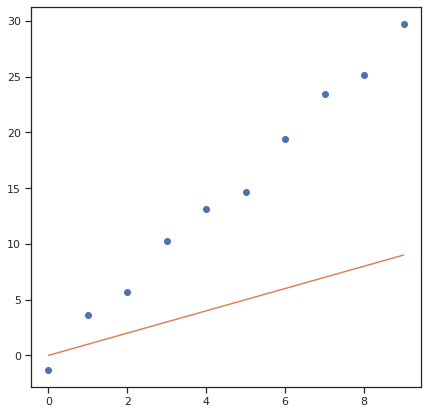

In [34]:
# Prepare the data
initial_parmas = torch.tensor([1., 0.])
target_params = torch.tensor([3.4, -0.8])

x = torch.tensor(range(10))
data = linear_model(x, target_params) + noise(x)

assert mse(linear_model(x, initial_parmas), data) > 100

show_fit(x, linear_model(x, initial_parmas), data)

Loss at epoch [0]: [142.34927368164062]
Loss at epoch [1]: [25.274545669555664]
Loss at epoch [2]: [5.046133041381836]
Loss at epoch [3]: [1.549175500869751]
Loss at epoch [4]: [0.9428154826164246]
Loss at epoch [5]: [0.8358668088912964]
Loss at epoch [6]: [0.8152238726615906]
Loss at epoch [7]: [0.8095152974128723]
Loss at epoch [8]: [0.8064106702804565]
Loss at epoch [9]: [0.803780198097229]


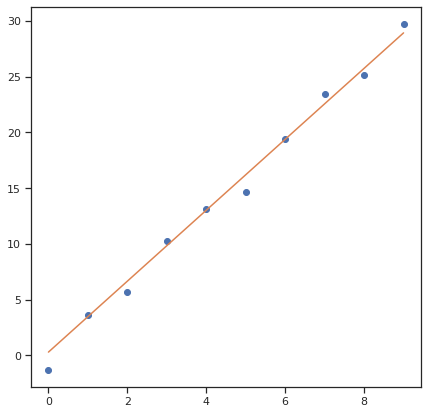

In [35]:
# TODO: Exercise
lr = 0.01
n_epochs = 10
initial_parmas = torch.tensor([1., 0.], requires_grad=True)

for epoch in range(n_epochs):
    # calculate loss
    loss = mse(linear_model(x, initial_parmas), data)
    print(f"Loss at epoch [{epoch}]: [{loss.item()}]")
    
    # calculate gradients / propagate error
    loss.backward()
    
    # update weights
    with torch.no_grad():
        initial_parmas -= lr * initial_parmas.grad.data
        initial_parmas.grad.data.zero_()
    
with torch.no_grad():
    show_fit(x, linear_model(x, initial_parmas), data)